In [42]:
from __future__ import division
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from salishsea_tools import nc_tools
from salishsea_tools import tidetools
%matplotlib inline

In [43]:
# read in old bathymetry
nc_filepath1 = '../../NEMO-forcing/grid/bathy_meter_SalishSea2.nc'
old_bathy = nc.Dataset(nc_filepath1, 'r')
old_depth = old_bathy.variables['Bathymetry']
print (old_depth[416, 335])

--


odict_keys(['nav_lon', 'nav_lat', 'deptht', 'time_counter', 'time_counter_bnds', 'sossheig', 'votemper', 'vosaline', 'rain_rate', 'snow_rate'])
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
[   0.5000003     1.5000031     2.50001144    3.50003052    4.50007057
    5.50015068    6.50031042    7.50062323    8.50123596    9.50243282
   10.50476551   11.50931168   12.51816654   13.53541183   14.56898212
   15.63428783   16.76117325   18.00713539   19.48178482   21.38997841
   24.10025597   28.22991562   34.68575668   44.51772308   58.48433304
   76.58558655   98.06295776  121.86651611  147.08946228  173.11448669
  199.57304382  226.26029968  253.06663513  279.93453979  306.834198
  333.75018311  360.67453003  387.60321045  414.53408813  441.46609497]


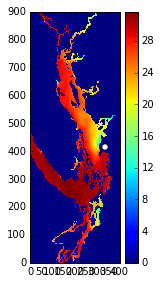

In [44]:
# read in old TS, this also gives the depths of the cells
nc_filepath2 = '/results/SalishSea/spin-up/2002/20dec25dec/SalishSea_1d_20021220_20021225_grid_T.nc'
TS = nc.Dataset(nc_filepath2, 'r')
old_salinity = TS.variables['vosaline'][5]
old_temperature = TS.variables['votemper'][5]
print (TS.variables.keys())
depths = TS.variables['deptht'][:]
lat = TS.variables['nav_lat'][:]
lon = TS.variables['nav_lon'][:]
print (old_salinity[:, 416, 335])
fig, ax = plt.subplots(1,1,figsize=(2,4.5))
mesh = ax.pcolormesh(old_salinity[0])
ax.plot(335, 416, 'ow')
fig.colorbar(mesh, ax=ax)
print (depths)

78.125
[ 31.569664    31.569664    31.569664    31.569664    31.56968117
  31.56978607  31.57003784  31.57058334  31.57172775  31.57310486
  31.57431602  31.57543373  31.57649231  31.57752228  31.57856941
  31.57966805  31.58087158  31.58225822  31.58394623  31.58621216
  31.58967209  31.59548378  31.60710907  31.62075615  31.63378334   0.           0.
   0.           0.           0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.           0.        ]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.]
14.125 --


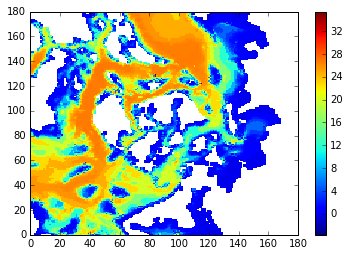

In [45]:
# read in new bathymetry
nc_filepath3 = '../../NEMO-forcing/grid/bathy_downonegrid.nc'
bathy = nc.Dataset(nc_filepath3, 'r')
depth = bathy.variables['Bathymetry'][:]
imin = 220-10
imax = 380+10
jmin = 210-10
jmax = 370+10
plt.pcolormesh(depth[imin:imax,jmin:jmax]-old_depth[imin:imax,jmin:jmax])
plt.colorbar()
print (depth[imin+20, jmin+20])
print (old_salinity[:, imin+20, jmin+20])
print (old_salinity[:, 416, 335])
print (depth[416, 335], old_depth[416, 335])

[   0.            1.0000006     2.00000572    3.00001717    4.00004387
    5.00009727    6.00020409    7.00041676    8.0008297     9.00164223
   10.00322342   11.0063076    12.01231575   13.02401733   14.04680634
   15.09115791   16.17741776   17.34492874   18.66934204   20.2942276
   22.48572922   25.71478271   30.74504852   38.62646484   50.40898132
   66.55968475   86.61148834  109.51442719  134.21859741  159.96032715
  186.26864624  212.87744141  239.64315796  266.4901123   293.37896729
  320.28942871  347.2109375   374.13812256  401.06829834  427.99987793]
[   1.0000006     2.00000572    3.00001717    4.00004387    5.00009727
    6.00020409    7.00041676    8.0008297     9.00164223   10.00322342
   11.0063076    12.01231575   13.02401733   14.04680634   15.09115791
   16.17741776   17.34492874   18.66934204   20.2942276    22.48572922
   25.71478271   30.74504852   38.62646484   50.40898132   66.55968475
   86.61148834  109.51442719  134.21859741  159.96032715  186.26864624
  212.

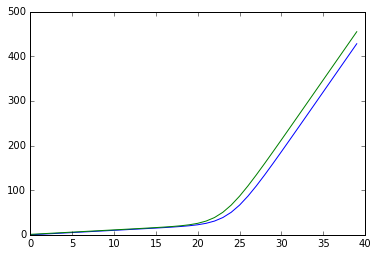

In [46]:
floor = np.empty_like(depths)
ceil = np.empty_like(depths)
ceil[0] = 0.
floor[0] = 2*depths[0]
for k in range(1,40):
    ceil[k] = floor[k-1]
    floor[k] = 2*depths[k] -floor[k-1]
plt.plot(ceil)
plt.plot(floor)
print (ceil)
print (floor)

In [119]:
S = np.empty_like(old_salinity)
T = np.empty_like(old_temperature)
# for every cell with top of cell depth < bathymetry, use old TS, if old TS=0, find closest point and use that.
for k in range(40):
    print (k)
    for j in range(398):
        for i in range(898):
            if ceil[k] < depth[i,j]:
                if old_salinity[k,i,j] != 0 or old_depth[i,j] == depth[i,j]:
                    S[k,i,j] = old_salinity[k, i, j]
                    T[k,i,j] = old_temperature[k, i, j]
                else:
                    # closest neighbour thing
                    masked_array = np.ma.array(old_salinity[k], mask = old_salinity[k] == 0)
                    X, Y = tidetools.find_closest_model_point(lon[i,j], lat[i,j], lon, lat, masked_array,
                                                             lon_tol=0.01, lat_tol= 0.003)
                    S[k, i, j] = old_salinity[k, X, Y]
                    T[k, i, j] = old_temperature[k, X, Y]
                    if k > 0 and S[k, i, j] < S[k-1, i, j]:
                        S[k, i, j] = S[k-1, i, j]
                        T[k, i, j] = T[k-1, i, j]
            elif k > 0 and depth[i,j] > 0:
                S[k, i, j] = S[k-1, i, j]
                T[k, i, j] = T[k-1, i, j]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39


In [120]:
print ('done')

done


In [100]:
for k in range(40):
    print k)
    for j in range(398):
        for i in range(898):
            if depth[i,j] != 0 and not S[k,i,j] > 0:
                print (k, i, j)
            if ceil[k] < depth[i,j]:
                if not (S[k,i,j] > 0):
                    print (i, j)
                    if old_salinity[k,i,j] != 0 or old_depth[i,j] == depth[i,j]:
                        S[k,i,j] = old_salinity[k, i, j]
                        T[k,i,j] = old_temperature[k, i, j]
                    else:
                        # closest neighbour thing
                        masked_array = np.ma.array(old_salinity[k], mask = old_salinity[k] == 0)
                        X, Y = tidetools.find_closest_model_point(lon[i,j], lat[i,j], lon, lat, masked_array,
                                                             lon_tol=0.01, lat_tol= 0.003)
                        S[k, i, j] = old_salinity[k, X, Y]
                        T[k, i, j] = old_temperature[k, X, Y]
                        print (S[k, i, j])

SyntaxError: Missing parentheses in call to 'print' (<ipython-input-100-5740bdb85f5b>, line 2)

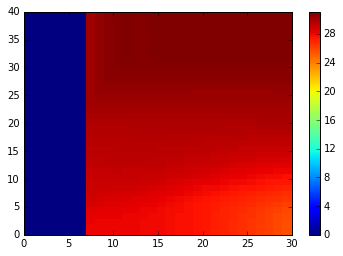

In [121]:
plt.pcolormesh(S[:, imin+100, jmin-10:jmax+10])
plt.colorbar()

In [123]:
print (lat[20,40])

47.0107


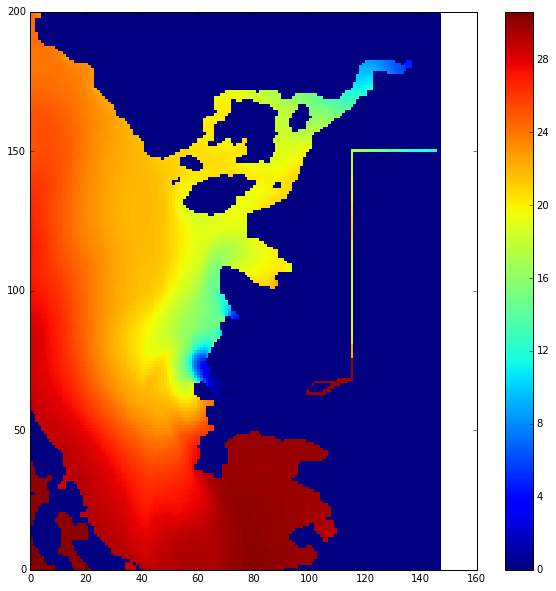

In [124]:
imin=350; imax=550; jmin=250; jmax=-1
id = 0
plt.figure(figsize=(10,10))
plt.pcolormesh(S[id, imin:imax, jmin:jmax])
plt.colorbar()

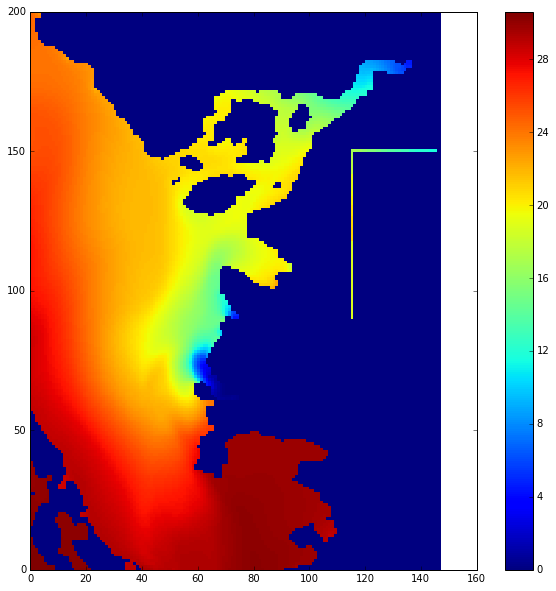

In [125]:
S[:,imin+50:imin+90,jmin+90:jmin+130] = 0
plt.figure(figsize=(10,10))
plt.pcolormesh(S[id, imin:imax, jmin:jmax])
plt.colorbar()

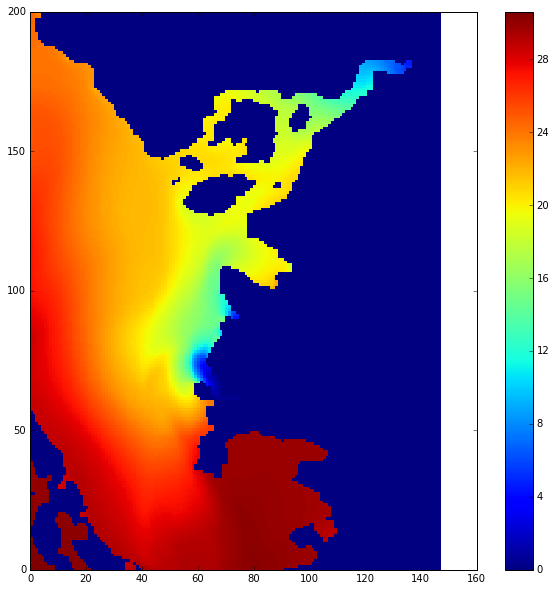

In [126]:
S[:,imin+50:imin+155,jmin+110:] = 0
plt.figure(figsize=(10,10))
plt.pcolormesh(S[id, imin:imax, jmin:jmax])
plt.colorbar()

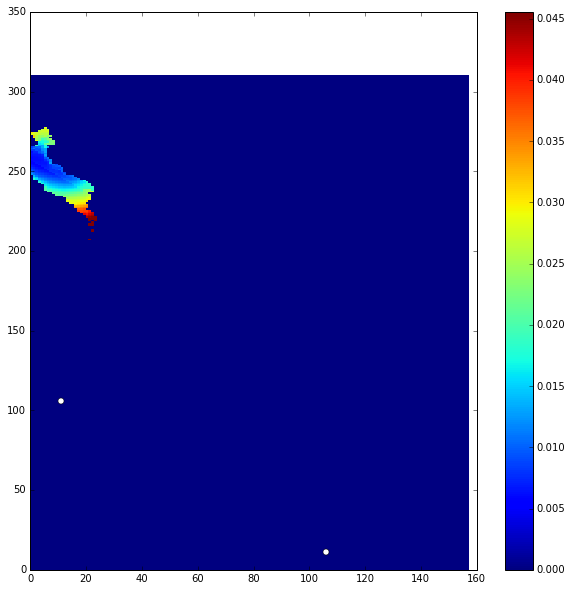

In [130]:
id=39
imin=240; imax=550; jmin=240; jmax=-1
plt.figure(figsize=(10,10))
plt.pcolormesh(S[id, imin:imax, jmin:jmax]-S[id-2, imin:imax, jmin:jmax])
plt.colorbar()
plt.plot(251-imin,346-jmin,'wo')
plt.plot(346-imin,251-jmin,'wo')

In [131]:
# build nc file
new_TS = nc.Dataset('TSforDeepenByGridThicknessDec.nc', 'w')
nc_tools.init_dataset_attrs(
    new_TS, 
    title='Salinity Temperature Initial Conditions based on Dec 2002 restart file', 
    notebook_name='Find TS for new Bathymetry', 
    nc_filepath='../../../nemo-forcing/initial_strat/TSforDeepenByGridThicknessDec.nc',
    comment='Salinity and Temperature conditions from Dec 2002 file for Deepen By Grid Thickness')
new_TS.createDimension('y', 898)
new_TS.createDimension('x', 398)
new_TS.createDimension('deptht',size = len(depths))
new_TS.createDimension('time_counter', None)
nc_tools.show_dimensions(new_TS)
# variables
nav_lat = new_TS.createVariable('nav_lat', 'float32', ('y','x'))
nav_lat.long_name = 'Latitude'
nav_lat.units = 'degrees_north'
nav_lat[:] = lat
nav_lon = new_TS.createVariable('nav_lon', 'float32', ('y','x'))
nav_lon.long_name = 'Longitude'
nav_lon.units = 'degrees_east'
nav_lon[:] = lon
deptht = new_TS.createVariable('deptht', 'float32', ('deptht'))
deptht.long_name = 'Depth'
deptht.units = 'm'
deptht.positive = 'down'
deptht[:] = depths
time_counter = new_TS.createVariable('time_counter', 'float32', ('time_counter'))
time_counter.units = 'irrelevant'
time_counter.long_name = 'Time axis'
vosaline = new_TS.createVariable('vosaline', 'float32', 
                               ('time_counter','deptht','y','x'))
vosaline.units = 'none'
vosaline.long_name = 'Practical Salinity'  
vosaline.coordinates = 'nav_lon nav_lat deptht time_counter'
vosaline.grid = 'Deepen by Grid Thickness'
vosaline[0] = S
votemper = new_TS.createVariable('votemper', 'float32', 
                               ('time_counter','deptht','y','x'))
votemper.units = 'degC'
votemper.long_name = 'Temperature' 
votemper.coordinates = 'nav_lon nav_lat deptht time_counter'
votemper[0] = T
new_TS.history = """[2016-02-01 Deepened]"""

file format: NETCDF4
Conventions: CF-1.6
title: Salinity Temperature Initial Conditions based on Dec 2002 restart file
institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
source: https://bitbucket.org/salishsea/tools/src/tip/Find TS for new Bathymetry.ipynb
references: REQUIRED
history: [2016-02-02 16:44:26] Created netCDF4 zlib=True dataset.
comment: Salinity and Temperature conditions from Dec 2002 file for Deepen By Grid Thickness
<class 'netCDF4._netCDF4.Dimension'>: name = 'y', size = 898

<class 'netCDF4._netCDF4.Dimension'>: name = 'x', size = 398

<class 'netCDF4._netCDF4.Dimension'>: name = 'deptht', size = 40

<class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time_counter', size = 0



In [132]:
new_TS.close()